In [ ]:
!pip install matplotlib deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.7 MB/s eta 0:00:00


gen	nevals	avg   	min     
0  	300   	322.04	0.962879
1  	220   	303.944	2.50449 
2  	240   	299.633	4.06862 
3  	229   	288.958	4.28064 
4  	228   	283.599	3.3317  
5  	218   	277.903	2.42108 
6  	220   	274.968	1.82587 
7  	232   	270.156	3.24966 
8  	223   	263.455	0.852384
9  	219   	252.869	0.852384
10 	251   	255.92 	3.02619 
11 	221   	244.897	2.57009 
12 	221   	226.087	1.65143 
13 	212   	215.351	1.65143 
14 	216   	207.919	3.41568 
15 	222   	205.301	3.41568 
16 	229   	201.555	3.96403 
17 	230   	202.229	4.42748 
18 	228   	200.113	3.96403 
19 	244   	196.48 	4.28588 
20 	223   	194.568	6.78793 
21 	222   	196.943	6.78793 
22 	223   	195.313	6.78793 
23 	218   	194.487	4.81955 
24 	240   	195.245	4.55351 
25 	227   	196.261	6.78793 
26 	235   	194.394	4.81955 
27 	235   	196.797	4.81955 
28 	235   	195.629	6.78793 
29 	240   	197.944	6.78793 
30 	235   	195.712	4.28588 
31 	232   	195.175	11.6792 
32 	229   	195.61 	4.47651 
33 	243   	196.813	4.28588 
34 	214   	195.959	4.8

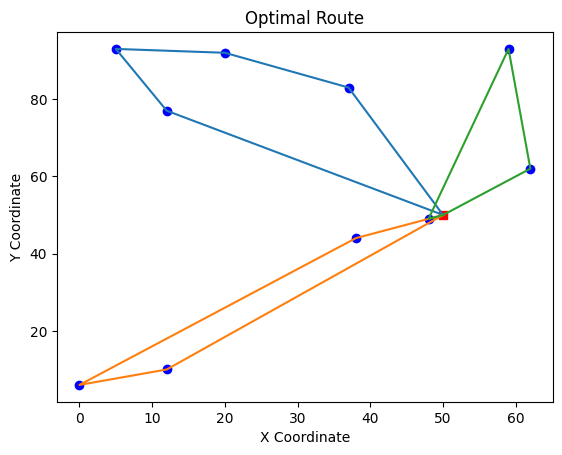

In [ ]:
# Required Libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Task 1 - Define the number of locations and vehicles
num_locations = 10  # Define how many locations (excluding the depot) the vehicles need to visit
locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(num_locations)]  # Generate random (x, y) coordinates for each location
depot = (50, 50)  # Define the central depot location as a fixed point
num_vehicles = 3  # Define how many vehicles are available to visit the locations

# Genetic Algorithm Setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))  # Define fitness function to minimize. The two objectives are total distance and balance penalty.
creator.create("Individual", list, fitness=creator.FitnessMin)  # Define individual structure. Individuals are lists with a fitness attribute.

# Task 2 - Finish setting up the individuals and population
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_locations), num_locations)  # Function to generate a list of unique, randomly ordered location indices
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)  # Function to create an individual as a shuffled list of location indices
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Function to create a population of individuals

# Fitness Function
def evalVRP(individual):
    total_distance = 0
    distances = []  # Track distance traveled by each vehicle for balance calculation
    # Split the list of locations among vehicles, ensuring each starts and ends at the depot
    for i in range(num_vehicles):
        vehicle_route = [depot] + [locations[individual[j]] for j in range(i, len(individual), num_vehicles)] + [depot]
        # Calculate total distance traveled by this vehicle
        vehicle_distance = sum(np.linalg.norm(np.array(vehicle_route[k+1]) - np.array(vehicle_route[k])) for k in range(len(vehicle_route)-1))
        total_distance += vehicle_distance
        distances.append(vehicle_distance)
    balance_penalty = np.std(distances)  # Use standard deviation of distances as a penalty for imbalance among vehicles
    return total_distance, balance_penalty

toolbox.register("evaluate", evalVRP)  # Register the evaluation function
toolbox.register("mate", tools.cxPartialyMatched)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Plotting Function
def plot_routes(individual, title="Routes"):
    plt.figure()
    # Plot locations as blue dots and the depot as a red square
    for (x, y) in locations:
        plt.plot(x, y, 'bo')
    plt.plot(depot[0], depot[1], 'rs')

    # Draw routes for each vehicle
    for i in range(num_vehicles):
        vehicle_route = [depot] + [locations[individual[j]] for j in range(i, len(individual), num_vehicles)] + [depot]
        plt.plot(*zip(*vehicle_route), '-')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

# Running the Genetic Algorithm
def main():
    random.seed(42)  # Seed for reproducibility
    pop = toolbox.population(n=300)  # Generate initial population
    hof = tools.HallOfFame(1)  # Hall of Fame to store the best individual

    # Setup statistics to track
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    # Run the genetic algorithm
    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 300, stats=stats, halloffame=hof)

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
    main()


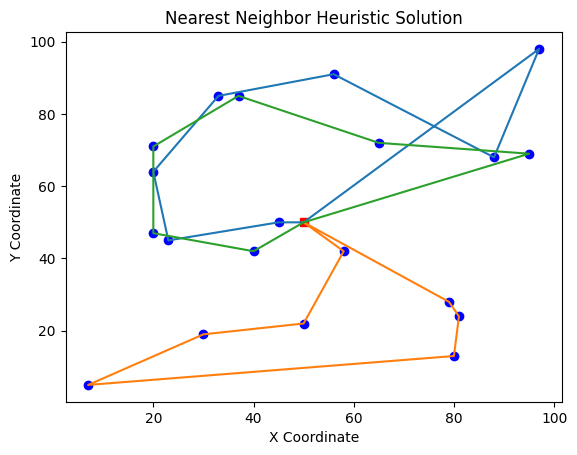

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define the number of locations and vehicles
num_locations = 20  # Define how many locations (excluding the depot) the vehicles need to visit
locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(num_locations)]  # Generate random (x, y) coordinates for each location
depot = (50, 50)  # Define the central depot location as a fixed point
num_vehicles = 3  # Define how many vehicles are available to visit the locations

# Nearest Neighbor Heuristic for Baseline Solution
def nearest_neighbor_baseline():
    remaining_locations = locations[:]
    routes = [[] for _ in range(num_vehicles)]
    current_positions = [depot] * num_vehicles

    for i in range(num_locations):
        for v in range(num_vehicles):
            if remaining_locations:
                next_loc = min(remaining_locations, key=lambda loc: np.linalg.norm(np.array(loc) - np.array(current_positions[v])))
                routes[v].append(next_loc)
                current_positions[v] = next_loc
                remaining_locations.remove(next_loc)

    # Plotting
    plt.figure()
    # Plot locations as blue dots and the depot as a red square
    for (x, y) in locations:
        plt.plot(x, y, 'bo')
    plt.plot(depot[0], depot[1], 'rs')

    # Draw routes for each vehicle
    for route in routes:
        vehicle_route = [depot] + route + [depot]
        plt.plot(*zip(*vehicle_route), '-')

    plt.title('Nearest Neighbor Heuristic Solution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

# Call the function to plot the nearest neighbor solution
nearest_neighbor_baseline()
